In [ ]:
from typing import Optional

import numpy as np

import jax
import jax.numpy as jnp
from transformers import AutoModel, AutoTokenizer

# Sun, apr 20

In [ ]:
from transformers import AutoModel, AutoTokenizer

# model_name = "bert-base-uncased"
model_name = "Qwen/Qwen2.5-0.5B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/7.23k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/681 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


In [ ]:
from transformers import AutoModelForCausalLM

In [ ]:
inputs = tokenizer("Hello, world!", return_tensors="pt")
input_ids = inputs['input_ids']
decoded_tokens = tokenizer.decode(input_ids[0])
print(decoded_tokens)
# tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
# tokens = [ 101, 7592, 1010, 2088,  999,  102]
tokens = inputs.input_ids.squeeze(0).tolist()
print(tokens)
words = tokenizer.convert_ids_to_tokens(tokens)
print(words)

Hello, world!
[9707, 11, 1879, 0]
['Hello', ',', 'Ġworld', '!']


In [ ]:
outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state
#for bert: outputs.last_hidden_states

In [ ]:
# Forward pass with attention outputs
outputs = model(**inputs, output_attentions=True)

# Access attention weights
attentions = outputs.attentions # Tuple of tensors

# Example: Attention from layer 0
layer_0_attention = attentions[0] # Shape: (batch_size, num_heads, seq_len, seq_len)
layer_last_attention = attentions[-1]
print(layer_last_attention.shape)

`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


torch.Size([1, 14, 4, 4])


In [ ]:
import numpy as np
import pandas as pd

batch_size, num_heads, seq_len, _ = layer_last_attention.shape
# print(seq_len)

# Reshape the tensor to 2D: combine batch_size and num_heads as rows,
# and flatten the seq_len x seq_len matrix into columns.
reshaped_attention = layer_last_attention.detach().reshape(batch_size * num_heads, seq_len * seq_len).cpu().numpy()

# Convert the reshaped array into a DataFrame
df = pd.DataFrame(reshaped_attention)

# Save the DataFrame to a CSV file without the index column
df.to_csv('attention_weights_qwen.csv', index=False)


generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Answer:  
John and his friends went shopping in the city center. They looked at many items,
but John decided to buy a red shirt for his daughter. She was very happy with her
new clothes. The girl's shirt is red.
 What color is John's daughter's shirt? (If the question is unanswerable, say "unanswerable")
red


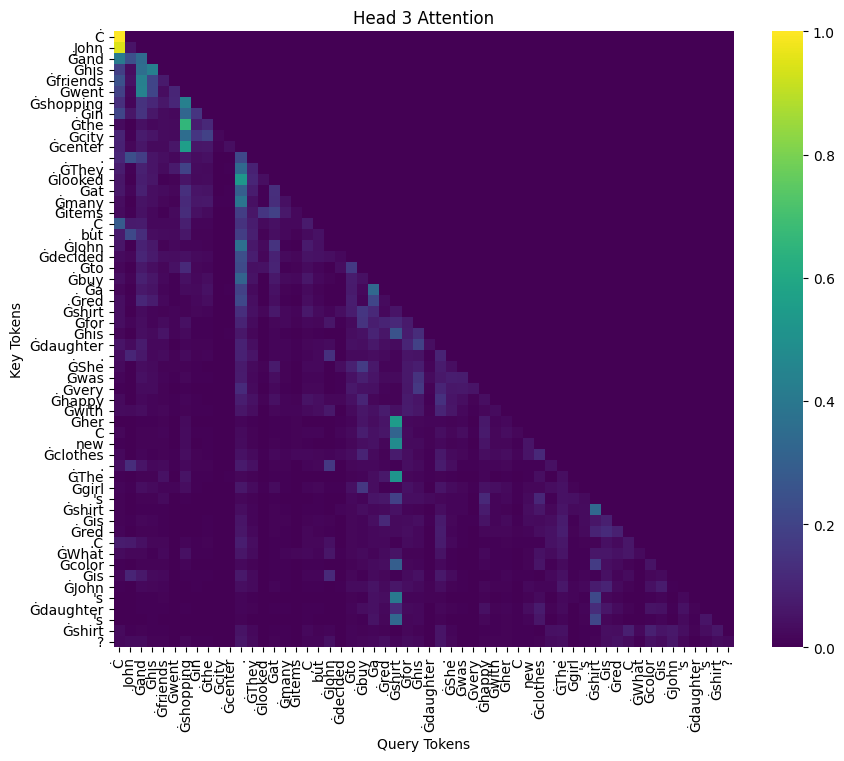

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure that plots display inline in Jupyter
%matplotlib inline

# Define a function to extract attention weights for each layer and head
def extract_attention_weights(model, tokenizer, input_text, device='tpu'):
    # Tokenize input text
    inputs = tokenizer(input_text, return_tensors="pt").to(device)

    # Forward pass with attention output
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    generated_ids = model.generate(**inputs)
    # Decode the generated IDs to obtain the text response
    generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    print("Answer: ", generated_text)
    # Extract attention matrices
    attentions = outputs.attentions  # List of attention matrices (one per layer)
    return attentions, inputs['input_ids']

# Visualize attention for a given layer and head
def visualize_attention(attention_matrix, input_ids, tokenizer, layer_idx, head_idx):
    # Extract token ids and convert them back to strings
    tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().cpu().numpy())

    # Normalize attention for better visualization
    attention = attention_matrix[layer_idx][0, head_idx].cpu().numpy()
    attention = attention / attention.sum(axis=-1, keepdims=True)  # Normalize rows

    # Plot the attention matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention, xticklabels=tokens, yticklabels=tokens, cmap="viridis")
    plt.title(f"Head {head_idx+1} Attention")
    plt.xlabel('Query Tokens')
    plt.ylabel('Key Tokens')
    plt.xticks(rotation=90)
    plt.show()

# Main function to extract and visualize attention
def main(input_text, model_name="Qwen/Qwen2.5-0.5B"):
    # Load the model and tokenizer
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

    # Extract attention weights
    attentions, input_ids = extract_attention_weights(model, tokenizer, input_text, device)

    # Choose a layer and head to visualize (can adjust based on which layer and head you want)
    layer_idx = -1  # Example: choose layer 5
    head_idx = 2   # Example: choose head 2

    # Visualize attention for the selected layer and head
    visualize_attention(attentions, input_ids, tokenizer, layer_idx, head_idx)

# Example of a "needle in haystack" task
context = """
John and his friends went shopping in the city center. They looked at many items,
but John decided to buy a red shirt for his daughter. She was very happy with her
new clothes. The girl's shirt is red.
"""
input_text = context + " " + "What color is John's daughter's shirt?"  # The question itself is part of the input


# Run the main function with the input text
main(input_text)

In [ ]:
import torch
from transformers import AutoModelForQuestionAnswering, AutoTokenizer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the Qwen model and tokenizer (replace with actual model name)
model_name = "Qwen/Qwen2.5-0.5B"  # Replace with actual model name
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForQuestionAnswering.from_pretrained(model_name, output_attentions=True)

# Define the question and context
question = "What is the capital of France?"
context = "Paris is the capital city of France, located in the northern part of the country."

# Tokenize the input
inputs = tokenizer(question, context, return_tensors="pt")

# Convert tensor to list to use index()
input_ids_list = inputs['input_ids'][0].tolist()

# Get the start and end indices of the context
context_start = input_ids_list.index(tokenizer.encode(context)[1])  # Find the start of context tokens
question_end = context_start - 1  # End of the question

# Get attention weights from the last layer
with torch.no_grad():
    outputs = model(**inputs, output_attentions=True)
    attentions = outputs.attentions  # List of attention matrices from each layer

# # Extract attention of the last layer (assuming it's the final transformer layer)
# last_layer_attention = attentions[-1]  # Shape: [batch_size, num_heads, seq_len, seq_len]

# # Get tokens corresponding to the question and context
# tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

# # Split attention into question and context indices
# context_tokens = tokens[context_start:]
# question_tokens = tokens[:context_start]

# # Get the attention matrix for context vs question
# attention_head = last_layer_attention[0, 0].cpu().numpy()  # Use first attention head

# # Create separate attention matrices for the question and context tokens
# context_attention = attention_head[len(question_tokens):, :len(context_tokens)]
# question_attention = attention_head[:len(question_tokens), :len(context_tokens)]

Some weights of Qwen2ForQuestionAnswering were not initialized from the model checkpoint at Qwen/Qwen2.5-0.5B and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight', 'transformer.embed_tokens.weight', 'transformer.layers.0.input_layernorm.weight', 'transformer.layers.0.mlp.down_proj.weight', 'transformer.layers.0.mlp.gate_proj.weight', 'transformer.layers.0.mlp.up_proj.weight', 'transformer.layers.0.post_attention_layernorm.weight', 'transformer.layers.0.self_attn.k_proj.bias', 'transformer.layers.0.self_attn.k_proj.weight', 'transformer.layers.0.self_attn.o_proj.weight', 'transformer.layers.0.self_attn.q_proj.bias', 'transformer.layers.0.self_attn.q_proj.weight', 'transformer.layers.0.self_attn.v_proj.bias', 'transformer.layers.0.self_attn.v_proj.weight', 'transformer.layers.1.input_layernorm.weight', 'transformer.layers.1.mlp.down_proj.weight', 'transformer.layers.1.mlp.gate_proj.weight', 'transformer.layers.1.mlp.up_proj.weight', 'transformer.layers.1.post_attention_laye

In [ ]:
# from transformers import pipeline

# # Load a pre-trained QA pipeline from Hugging Face
# qa_pipeline = pipeline("question-answering", model="distilbert-base-uncased-distilled-squad")

# # Define the context and question
# context = "Hugging Face is a company specializing in Natural Language Processing (NLP). It has developed some of the most widely used transformer models for tasks such as question answering, text generation, and classification."
# question = "What does Hugging Face specialize in?"

# # Get the answer using the pipeline
# result = qa_pipeline(question=question, context=context)

# # Print the result
# print(f"Answer: {result['answer']}")

In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, pipeline

# # Load the Qwen model and tokenizer for QA
# model_name = "Qwen/Qwen2-72B"  # Replace with the correct Qwen model path

# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForQuestionAnswering.from_pretrained(model_name)

# # Use Hugging Face's pipeline for QA with Qwen model
# qa_pipeline = pipeline("question-answering", model=model, tokenizer=tokenizer)

# # Define your context and question
# context = """
# Qwen-2 is an advanced model designed for natural language understanding and generation.
# It can perform a wide variety of tasks, including question answering, text summarization, and sentiment analysis.
# """
# question = "What tasks can Qwen-2 perform?"

# # Get the answer using the pipeline
# result = qa_pipeline(question=question, context=context)

# # Print the result
# print(f"Answer: {result['answer']}")

In [ ]:
# Extract attention of the last layer (assuming it's the final transformer layer)
last_layer_attention = attentions[-1]  # Shape: [batch_size, num_heads, seq_len, seq_len]

# Get tokens corresponding to the question and context
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

# Split attention into question and context indices
context_tokens = tokens[context_start:]
question_tokens = tokens[:context_start]

# Get the attention matrix for context vs question
attention_head = last_layer_attention[0, 0].cpu().numpy()  # Use first attention head

# Create separate attention matrices for the question and context tokens
context_attention = attention_head[len(question_tokens):, :len(context_tokens)]
question_attention = attention_head[:len(question_tokens), :len(context_tokens)]

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


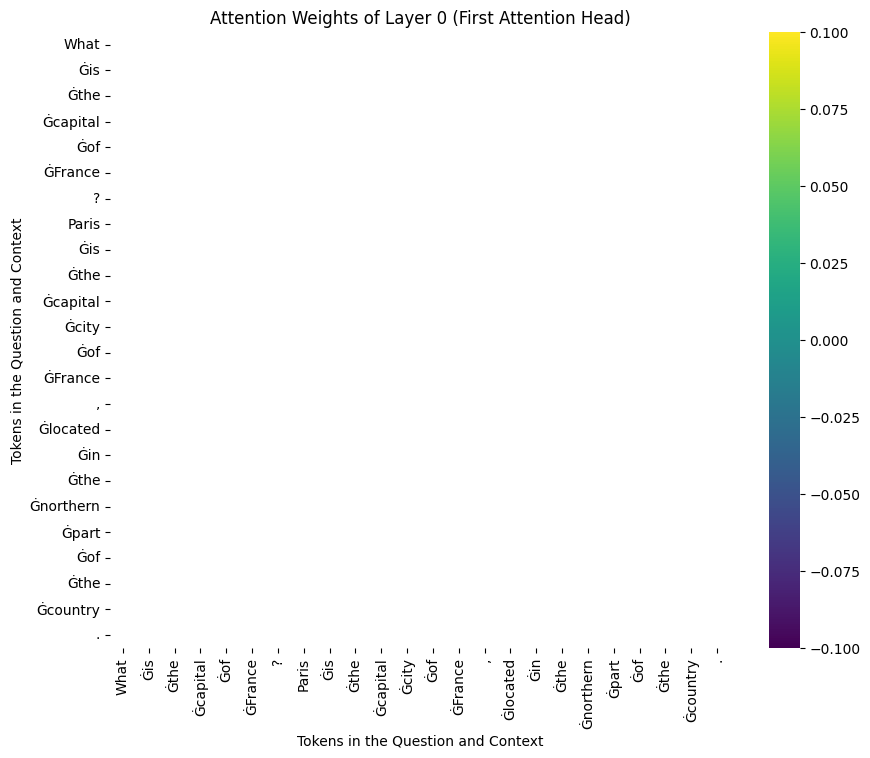

In [ ]:
# Extract attention weights from the model outputs
attention_weights = outputs.attentions  # This is a tuple of attention matrices

# Select the attention weights from a specific layer (e.g., layer 0)
# Each layer has a shape of (batch_size, num_heads, sequence_length, sequence_length)
#print(attention_weights.shape)
layer_attention = attention_weights[0][0]  # Get attention from the first layer, first head

layer_attention = layer_attention[0]

# Plot the attention weights as a heatmap
plt.figure(figsize=(10, 8))

xticklabels=tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
yticklabels=tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

sns.heatmap(layer_attention.cpu().numpy(), cmap="viridis", xticklabels=xticklabels, yticklabels=yticklabels, cbar=True)
plt.title("Attention Weights of Layer 0 (First Attention Head)")
plt.xlabel("Tokens in the Question and Context")
plt.ylabel("Tokens in the Question and Context")
plt.show()

In [ ]:
()

()

# New Stuff

In [ ]:
# Prompts generated with GPT
# Example 1: Question + Context requiring a comparison of multiple entities
question_1 = "How does the Eiffel Tower compare to other famous landmarks?"
context_1 = "The Eiffel Tower, built in 1889, is one of the most iconic landmarks in the world. The Great Wall of China, stretching over 13,000 miles, is another historical marvel. The Pyramids of Giza, constructed around 2580 BC, also rank among the Seven Wonders of the Ancient World. Each of these landmarks represents unique aspects of their respective cultures, from engineering feats to architectural ingenuity."

# Example 2: Question + Context asking for multiple causal relationships
question_2 = "What factors led to the construction of the Eiffel Tower?"
context_2 = "The Eiffel Tower was designed by Gustave Eiffel as part of the 1889 World’s Fair in Paris, which aimed to showcase the latest in industrial design and engineering. France’s desire to demonstrate its technological prowess on the world stage was a major motivator. Additionally, the tower’s unique design was chosen to symbolize modernity and innovation in a rapidly industrializing world. Though initially criticized, the tower became a symbol of French cultural pride."

# Example 3: Question + Context with complex reasoning involving historical context
question_3 = "What historical events influenced the creation of the Eiffel Tower?"
context_3 = "The Eiffel Tower was conceived as a centerpiece for the 1889 Exposition Universelle, a world's fair held in Paris to celebrate the 100th anniversary of the French Revolution. This event itself was a product of the rapid industrialization of France in the late 19th century, as well as the nation’s desire to demonstrate its scientific and cultural dominance. The tower’s construction was a reflection of France’s ambitions and the optimism of the Industrial Revolution."

# Example 4: Question + Context requiring the model to understand different perspectives
question_4 = "What is the significance of the Eiffel Tower in French culture and history?"
context_4 = "The Eiffel Tower, completed in 1889, initially faced criticism for its design but eventually became one of the most recognized symbols of France. Over time, it came to represent French engineering excellence, and its central location in Paris made it a cultural landmark. The tower has been featured in countless films, art pieces, and literature, symbolizing France’s creativity and innovation. It also represents the resilience of France, having survived both world wars."

# Example 5: Question + Context asking for a sequence of events
question_5 = "How did the Eiffel Tower come to be one of the most visited monuments in the world?"
context_5 = "The Eiffel Tower was initially built as a temporary structure for the 1889 World's Fair in Paris, meant to demonstrate French technological prowess. After the fair, it was almost dismantled, but its usefulness as a communications tower led to its preservation. Over time, its cultural and architectural significance grew, and it became a popular tourist destination. Today, it attracts millions of visitors each year, becoming a symbol of Paris and France's industrial heritage."

# Example 6: Question + Context exploring a thematic or cultural comparison
question_6 = "How does the Eiffel Tower symbolize French identity compared to other landmarks?"
context_6 = "The Eiffel Tower stands as one of the most recognizable symbols of France, representing the nation's strength, creativity, and historical legacy. Similarly, landmarks like the Statue of Liberty in the United States represent ideals of freedom and democracy. While the Statue of Liberty speaks to a nation of immigrants, the Eiffel Tower embodies France’s deep historical ties to art, science, and revolutionary thought. Both landmarks are central to their nation's identity, but in very different cultural contexts."


In [ ]:
questions = [question_1, question_2, question_3, question_4, question_5, question_6]
contexts = [context_1, context_2, context_3, context_4, context_5, context_6]

In [ ]:
# prompt: create a qa_pipeline with roberta, NOT qwen

from transformers import pipeline

# Load the Roberta model and tokenizer for QA
model_name = "deepset/roberta-base-squad2"  # Replace with the correct Roberta model path
qa_pipeline = pipeline("question-answering", model=model_name)


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/496M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/79.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

model_name = "deepset/roberta-base-squad2"# "distilbert-base-uncased-distilled-squad"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForQuestionAnswering.from_pretrained(
    model_name, output_attentions=True
)
qa_pipeline = pipeline("question-answering", model=model, tokenizer=tokenizer)

i = 1
for question, context in zip(questions, contexts):
    inputs = tokenizer(question, context, return_tensors="pt")

    # Perform forward pass with attention
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
        attentions = outputs.attentions

    # Extract attention weights
    attentions = outputs.attentions

    # Sum across the attention heads
    summed_attentions = [torch.sum(layer, dim=1) for layer in attentions]

    # Sum across the layers
    final_attention = torch.sum(torch.stack(summed_attentions), dim=0)

    # Convert to numpy for visualization (optional)
    final_attention_np = final_attention.cpu().numpy()[0]

    # token ids -> actual workds
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    result = qa_pipeline(question=question, context=context)
    print(f"Answer: {result['answer']}")

    # Plot the attention weights
    plt.figure(figsize=(25, 20))

    # Create a custom monochromatic colormap where 0 is white
    colors = ["white", "purple"]  # Start from white (0) and go to black (max value)
    nodes = [0, 1]  # Corresponding positions for the colors

    # Create a LinearSegmentedColormap
    cmap = LinearSegmentedColormap.from_list("monochrome_cmap", list(zip(nodes, colors)))

    sns.heatmap(
        final_attention_np, cmap=cmap, xticklabels=tokens, yticklabels=tokens, cbar=True
    )
    plt.title(f"QA{i}: {result['answer']}")
    plt.xlabel("Tokens in the Question and Context")
    plt.ylabel("Tokens in the Question and Context")
    plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
    plt.show()
    i+= 1


Device set to use cuda:0


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)

In [ ]:
# 1) Fully‐filled QA pairs
questions = [
    "How does the Eiffel Tower compare to other famous landmarks?",
    "What factors led to the construction of the Eiffel Tower?",
    "What historical events influenced the creation of the Eiffel Tower?",
    "What is the significance of the Eiffel Tower in French culture and history?",
    "How did the Eiffel Tower come to be one of the most visited monuments in the world?",
    "How does the Eiffel Tower symbolize French identity compared to other landmarks?"
]

contexts = [
    # context_1
    "The Eiffel Tower, built in 1889, is one of the most iconic landmarks in the world. "
    "The Great Wall of China, stretching over 13,000 miles, is another historical marvel. "
    "The Pyramids of Giza, constructed around 2580 BC, also rank among the Seven Wonders of the Ancient World. "
    "Each of these landmarks represents unique aspects of their respective cultures, from engineering feats to architectural ingenuity.",
    # context_2
    "The Eiffel Tower was designed by Gustave Eiffel as part of the 1889 World’s Fair in Paris, which aimed to showcase the latest in industrial design and engineering. "
    "France’s desire to demonstrate its technological prowess on the world stage was a major motivator. "
    "Additionally, the tower’s unique design was chosen to symbolize modernity and innovation in a rapidly industrializing world. "
    "Though initially criticized, the tower became a symbol of French cultural pride.",
    # context_3
    "The Eiffel Tower was conceived as a centerpiece for the 1889 Exposition Universelle, a world's fair held in Paris to celebrate the 100th anniversary of the French Revolution. "
    "This event itself was a product of the rapid industrialization of France in the late 19th century, as well as the nation’s desire to demonstrate its scientific and cultural dominance. "
    "The tower’s construction was a reflection of France’s ambitions and the optimism of the Industrial Revolution.",
    # context_4
    "The Eiffel Tower, completed in 1889, initially faced criticism for its design but eventually became one of the most recognized symbols of France. "
    "Over time, it came to represent French engineering excellence, and its central location in Paris made it a cultural landmark. "
    "The tower has been featured in countless films, art pieces, and literature, symbolizing France’s creativity and innovation. "
    "It also represents the resilience of France, having survived both world wars.",
    # context_5
    "The Eiffel Tower was initially built as a temporary structure for the 1889 World's Fair in Paris, meant to demonstrate French technological prowess. "
    "After the fair, it was almost dismantled, but its usefulness as a communications tower led to its preservation. "
    "Over time, its cultural and architectural significance grew, and it became a popular tourist destination. "
    "Today, it attracts millions of visitors each year, becoming a symbol of Paris and France's industrial heritage.",
    # context_6
    "The Eiffel Tower stands as one of the most recognizable symbols of France, representing the nation's strength, creativity, and historical legacy. "
    "Similarly, landmarks like the Statue of Liberty in the United States represent ideals of freedom and democracy. "
    "While the Statue of Liberty speaks to a nation of immigrants, the Eiffel Tower embodies France’s deep historical ties to art, science, and revolutionary thought. "
    "Both landmarks are central to their nation's identity, but in very different cultural contexts."
]

In [ ]:
# from GPT:
contexts = [
    # Simple Needle
    "The Earth revolves around the Sun. This movement causes day and night on Earth.",

    # Split Needle
    "Isaac Newton was born in 1643. He made significant contributions to physics. "
    "His theory of gravity explained planetary motion.",

    # Paraphrased Needle
    "The French capital, Paris, known for its iconic Eiffel Tower, attracts millions of tourists annually. "
    "It is one of Europe's major cities of art and fashion.",

    # Implied Needle
    "She set her alarm for 5:00 AM and packed her running shoes before going to bed. "
    "At dawn, she was already jogging through the park.",

    # Coreference Resolution
    "Marie Curie won the Nobel Prize in Physics in 1903. She later received a second Nobel Prize in Chemistry. "
    "Her work on radioactivity changed science forever.",

    # Distractor Needle
    "Washington, D.C. is the capital of the United States. New York is the most populous U.S. city. "
    "Los Angeles is famous for Hollywood. Chicago is known for its architecture."
]

questions = [
    "What does the Earth revolve around?",
    "Whose theory explained planetary motion?",
    "What is the capital of France?",
    "What did she do early in the morning?",
    "Who received two Nobel Prizes?",
    "What is the capital of the United States?"
]

answers = [
    "The Earth revolves around the Sun.",
    "Isaac Newton's theory of gravity explained planetary motion.",
    "Paris is the capital of France.",
    "She went for a run early in the morning.",
    "Marie Curie received two Nobel Prizes.",
    "Washington, D.C. is the capital of the United States."
]

# Example iteration
for context, question, answer in zip(contexts, questions, answers):
    print("Context:", context)
    print("Question:", question)
    print("Answer:", answer)
    print("---")


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, pipeline



# 2) Load model + tokenizer
model_name  = "deepset/roberta-base-squad2"
tokenizer   = AutoTokenizer.from_pretrained(model_name)
model       = AutoModelForQuestionAnswering.from_pretrained(model_name, output_attentions=True)
qa_pipeline = pipeline("question-answering", model=model, tokenizer=tokenizer)

# tokens to drop (specials, punctuation)
bad_tokens = set(tokenizer.all_special_tokens) | {".", ",", "?", "!"}

for example_id, (question, context) in enumerate(zip(questions, contexts), start=1):
    # --- Full‐sequence tokenize ---
    inputs    = tokenizer(question, context, return_tensors="pt")
    input_ids = inputs["input_ids"][0]
    tokens    = tokenizer.convert_ids_to_tokens(input_ids)

    # --- Separate Q vs. C lengths (no specials) ---
    q_toks = tokenizer.tokenize(question, add_special_tokens=False)
    c_toks = tokenizer.tokenize(context,  add_special_tokens=False)
    q_len, c_len = len(q_toks), len(c_toks)

    # --- Compute index ranges ---
    # [<s>] + q_toks + [</s>] + c_toks + [</s>]
    q_indices = list(range(1, 1 + q_len))
    c_indices = list(range(1 + q_len + 1, 1 + q_len + 1 + c_len))

    # --- Forward pass & collect attentions ---
    with torch.no_grad():
        outputs    = model(**inputs)
    attentions   = outputs.attentions

    result = qa_pipeline(question=question, context=context)
    print(f"Answer: {result['answer']}")

    # --- Sum heads & layers into an (L×L) matrix ---
    summed   = [layer_attn.squeeze(0).sum(dim=0) for layer_attn in attentions]
    attn_mat = torch.stack(summed).sum(dim=0).cpu().numpy()

    # --- Row‑normalize by row mean ---
    row_means = attn_mat.mean(axis=1, keepdims=True)
    norm_attn = attn_mat / (row_means + 1e-6)

    # --- Unique, filtered token lists ---
    unique_q, unique_c = [], []
    for tok in q_toks:
        clean = tok.lstrip("Ġ")
        if clean and clean not in bad_tokens and clean not in unique_q:
            unique_q.append(clean)
    for tok in c_toks:
        clean = tok.lstrip("Ġ")
        if clean and clean not in bad_tokens and clean not in unique_c:
            unique_c.append(clean)

    n_q, n_c = len(unique_q), len(unique_c)
    M_qc      = np.zeros((n_q, n_c), dtype=float)

    # --- Aggregate by averaging over occurrences ---
    for i_q, tok_q in enumerate(unique_q):
        rows = [idx for idx in q_indices if tokens[idx].lstrip("Ġ") == tok_q]
        for j_c, tok_c in enumerate(unique_c):
            cols = [idx for idx in c_indices if tokens[idx].lstrip("Ġ") == tok_c]
            if rows and cols:
                M_qc[i_q, j_c] = norm_attn[np.ix_(rows, cols)].mean()

    # --- Plot Q→C heatmap ---
    plt.figure(figsize=(n_c * .5 + 2, n_q * .5 + 2))
    im = plt.imshow(M_qc, aspect="auto", cmap="magma")
    plt.colorbar(im, label="Avg. norm. attn")
    plt.yticks(range(n_q), unique_q, fontsize=10)
    plt.xticks(range(n_c), unique_c, rotation=90, fontsize=8)
    plt.xlabel("Context tokens (unique)")
    plt.ylabel("Question tokens (unique)")
    plt.title(f"Example {example_id}: Q→C Attention. Answer = {result['answer']}")
    plt.tight_layout()
    plt.show()

    # --- Plot context retrieval strength ---
    retrieval_strength = M_qc.mean(axis=0)
    plt.figure(figsize=(n_c * .3 + 2, 3))
    plt.bar(range(n_c), retrieval_strength, color="C1")
    plt.xticks(range(n_c), unique_c, rotation=90, fontsize=8)
    plt.ylabel("Avg. Q→C attn")
    plt.title(f"Example {example_id}: Retrieval Strength")
    plt.tight_layout()
    plt.show()


# Needle in Haystack

In [ ]:
def insert_needle_at_depth(base_text, needle, depth_percent):
    """Insert the needle at a given percentage depth in the base text."""
    words = base_text.split()
    insert_index = int(len(words) * depth_percent)
    new_words = words[:insert_index] + [needle] + words[insert_index:]
    return ' '.join(new_words)

def generate_depth_contexts(base_haystack, needle, question):
    """Generate contexts with the needle at different depths."""
    depths = [0.0, 0.25, 0.5, 0.75, 1.0]
    samples = []
    for depth in depths:
        context = insert_needle_at_depth(base_haystack, needle, depth)
        samples.append({
            "depth": depth,
            "context": context,
            "question": question,
            "answer": needle
        })
    return samples

# EXAMPLE USAGE
base_haystack = (
    "This is a long piece of context that doesn't contain the answer yet. "
    "It talks about a lot of unrelated things such as history, science, and philosophy. "
    "There are mentions of various historical events, scientific discoveries, and philosophical ideas. "
    "The text continues to expand with random but coherent information to simulate a realistic background."
)

needle = "Prof. Dhillijon teaches at machine learning UT Austin?"
question = "What teaches machine learning at ut austin?"

# Generate contexts with the needle at 0%, 25%, 50%, 75%, and 100%
samples = generate_depth_contexts(base_haystack, needle, question)
samples
# # Optionally export to CSV
# import csv
# with open("qa_depth_contexts.csv", "w", newline='', encoding='utf-8') as f:
#     writer = csv.DictWriter(f, fieldnames=["depth", "context", "question", "answer"])
#     writer.writeheader()
#     writer.writerows(samples)

# from google.colab import files
# files.download("qa_depth_contexts.csv")


In [ ]:
pip install sentence-transformers scikit-learn

In [ ]:
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load a sentence transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')  # small, fast, good general-purpose model

# Sample haystacks
haystacks = [
    "The Eiffel Tower is located in Paris and is one of the most visited landmarks in the world.",
    "Mount Everest is the highest mountain in the world, standing at 8,848 meters.",
    "Photosynthesis is the process by which green plants make food using sunlight.",
    "Venus is the second planet from the Sun and has a very thick atmosphere.",
    "Bananas are high in potassium and make a great snack."
]

# Needle queries + correct index for where the answer is
queries = [
    ("Where is the Eiffel Tower?", 0),
    ("What is the tallest mountain?", 1),
    ("How do plants make food?", 2),
    ("What is the capital of France?", None),  # needle not present
    ("What fruit is high in potassium?", 4)
]

# Encode haystacks only once
haystack_embeddings = model.encode(haystacks, convert_to_tensor=True)

# Evaluate
y_true = []
y_pred = []

for query_text, correct_index in queries:
    query_embedding = model.encode(query_text, convert_to_tensor=True)

    # Compute cosine similarities
    cosine_scores = util.cos_sim(query_embedding, haystack_embeddings)[0]
    top_match_index = cosine_scores.argmax().item()

    # If cosine similarity is above a certain threshold (optional), consider it a match
    found = top_match_index == correct_index if correct_index is not None else False

    y_true.append(1 if correct_index is not None else 0)
    y_pred.append(1 if found else 0)

    print(f"Query: {query_text}")
    print(f"Top match: {haystacks[top_match_index]}")
    print(f"Correct? {'✅' if found else '❌'}\n")

# Compute metrics
print("Results:")
print(f"Accuracy:  {accuracy_score(y_true, y_pred):.2f}")
print(f"Precision: {precision_score(y_true, y_pred):.2f}")
print(f"Recall:    {recall_score(y_true, y_pred):.2f}")
print(f"F1 Score:  {f1_score(y_true, y_pred):.2f}")

In [ ]:
pip install bert-score

In [ ]:
from transformers import pipeline
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from bert_score import score

# Load QA and embedding models
qa_pipeline = pipeline("question-answering", model="deepset/roberta-base-squad2")
embed_model = SentenceTransformer('all-MiniLM-L6-v2')

# Data: haystacks and expected answers
haystacks = [
    "Apples help keep the doctor away",
    "The Eiffel Tower is located in Paris and is one of the most visited landmarks in the world.",
    "Mount Everest is the highest mountain in the world, standing at 8,848 meters.",
    "Photosynthesis is the process by which green plants make food using sunlight.",
    "Venus is the second planet from the Sun and has a very thick atmosphere.",
    "Bananas are high in potassium and make a great snack."
]

haystack_combined = " ".join(haystacks)

queries = [
    ("Where is the Eiffel Tower?", "Paris"),
    ("What is the tallest mountain?", "Mount Everest"),
    ("How do plants make food?", "Plants make food using photosynthesis"),
    ("What is the capital of France?", None),  # no answer
    ("What fruit is high in potassium?", "Bananas"),
    ("What are two great fruits to eat?", "Bananas and Apples")
]

# Cosine similarity threshold
SIM_THRESHOLD = 0.7

# Evaluation setup
y_true = []
y_pred = []

predicted_answers = []
expected_answers = []

for question, expected_answer in queries:
    #best_score = 0
    #answer = ""

    # Calculate the best answer
    result = qa_pipeline(question=question, context=haystack_combined)
    answer = result["answer"]

    # Check similarity only if an expected answer is defined
    if expected_answer is not None:
        emb_pred = embed_model.encode(answer, convert_to_tensor=True)
        emb_true = embed_model.encode(expected_answer, convert_to_tensor=True)
        cosine_sim = util.cos_sim(emb_pred, emb_true).item()
        match = cosine_sim >= SIM_THRESHOLD
        # Compute BERTScore between predicted and expected answer
        P, R, F1 = score([answer], [expected_answer], lang="en", verbose=False)
        semantic_match = F1.item() >= 0.85  # adjust threshold as needed
    else:
        match = False  # No answer expected; any answer is incorrect
        semantic_match = False

    y_true.append(1 if expected_answer else 0)
    y_pred.append(1 if match else 0)

    #predicted_answers.append(answer)
    #append(expected_answer)

    print(f"Q: {question}")
    print(f"✔ Expected: {expected_answer}")
    print(f"🔍 Predicted: {answer}")
    if expected_answer:
        print(f"📐 Cosine Sim: {cosine_sim:.2f}")
    print(f"Match: {'Yes' if match else 'No'}\n")

    print(f"BERTScore F1: {F1.item():.4f}")
    print(f"Needle Found? {'Yes ✅' if semantic_match else 'No ❌'}")

    # Print BERTScore
    print(f"BERTScore Precision: {P.item():.4f}")
    print(f"BERTScore Recall: {R.item():.4f}")
    print(f"BERTScore F1: {F1.item():.4f}")

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

model_name = "deepset/roberta-base-squad2"# "distilbert-base-uncased-distilled-squad"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForQuestionAnswering.from_pretrained(
    model_name, output_attentions=True
)
qa_pipeline = pipeline("question-answering", model=model, tokenizer=tokenizer)

queries = [
    ("Where is the Eiffel Tower?", "Paris"),
    ("What is the tallest mountain?", "Mount Everest"),
    ("How do plants make food?", "Photosynthesis"),
    ("What is the capital of France?", None),  # no answer
    ("What fruit is high in potassium?", "Bananas")
]

# Cosine similarity threshold
SIM_THRESHOLD = 0.7

# Evaluation setup
y_true = []
y_pred = []


i=1
for question, expected_answer in queries:
    inputs = tokenizer(question, context, return_tensors="pt")

    # Perform forward pass with attention
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
        attentions = outputs.attentions

    # Extract attention weights
    attentions = outputs.attentions

    # Sum across the attention heads
    summed_attentions = [torch.sum(layer, dim=1) for layer in attentions]

    # Sum across the layers
    final_attention = torch.sum(torch.stack(summed_attentions), dim=0)

    # Convert to numpy for visualization (optional)
    final_attention_np = final_attention.cpu().numpy()[0]

    # token ids -> actual workds
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    result = qa_pipeline(question=question, context=context)
    print(f"Answer: {result['answer']}")

    # Plot the attention weights
    plt.figure(figsize=(25, 20))

    # Create a custom monochromatic colormap where 0 is white
    colors = ["white", "purple"]  # Start from white (0) and go to black (max value)
    nodes = [0, 1]  # Corresponding positions for the colors

    # Create a LinearSegmentedColormap
    cmap = LinearSegmentedColormap.from_list("monochrome_cmap", list(zip(nodes, colors)))

    sns.heatmap(
        final_attention_np, cmap=cmap, xticklabels=tokens, yticklabels=tokens, cbar=True
    )
    plt.title(f"QA{i}: {result['answer']}")
    plt.xlabel("Tokens in the Question and Context")
    plt.ylabel("Tokens in the Question and Context")
    plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
    plt.show()
    i+= 1

# Bertviz Stuff

In [ ]:
# !pip install bertviz

In [ ]:
def insert_needle_at_depth(base_text, needle, depth_percent):
    """Insert the needle at a given percentage depth in the base text."""
    words = base_text.split()
    insert_index = int(len(words) * depth_percent)
    new_words = words[:insert_index] + [needle] + words[insert_index:]
    return ' '.join(new_words)

In [ ]:
# Tokenize the context and get the token IDs
def get_token_length(txt):
    tokens = tokenizer.encode(txt, add_special_tokens=True)  # `add_special_tokens=True` adds [CLS] and [SEP] tokens

    # Get the length of the tokenized context
    token_length = len(tokens)
    return token_length
get_token_length(needle), get_token_length(context)

In [ ]:
# Import necessary libraries
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, pipeline
from bertviz import head_view, model_view
import torch

# Step 1: Load the pre-trained RoBERTa model and tokenizer
model_name = "deepset/roberta-base-squad2"  # You can use any RoBERTa model fine-tuned for Q&A tasks
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForQuestionAnswering.from_pretrained(
    model_name, output_attentions=True
)

# Step 2: Define the context (passage) and question
# EXAMPLE USAGE
base_haystack = (
    "This is a long piece of context that doesn't contain the answer yet. "
    "It talks about a lot of unrelated things such as history, science, and philosophy. "
    "There are mentions of various historical events, scientific discoveries, and philosophical ideas. "
    "The text continues to expand with random but coherent information to simulate a realistic background."
)

needle = "Prof. Dhillon teaches at machine learning UT Austin."
context = insert_needle_at_depth(base_haystack, needle, 0.25)
question = "What teaches machine learning at ut austin?"

# Step 3: Tokenize the input question and context
inputs = tokenizer.encode_plus(question, context, add_special_tokens=True, return_tensors="pt")

# Step 4: Perform the forward pass to get the attention weights
outputs = model(**inputs, output_attentions=True, return_dict=True)

# Step 5: Extract attention weights from the output
attentions = outputs.attentions

result = qa_pipeline(question=question, context=context)
print(f"Answer: {result['answer']}")


In [ ]:
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
model_view(attentions, tokens)  # Display model view

In [ ]:
html_output = head_view(attentions, tokens, layer=2, heads=[8])
html_output

In [ ]:
from IPython.core.display import display, HTML

In [ ]:
# Save the plot as an HTML file
html_head_view = head_view(attentions, tokens, html_action='return')

with open("/content/attention_plot.html", 'w') as file:
    file.write(html_head_view.data)
#
# with open(html_filename, "w") as f:
#     f.write("<html>\n<body>\n")
#     f.write("<h1>Attention Visualization</h1>\n")
#     f.write("<div>")
#     f.write(str(display(HTML(html_filename))))
#     f.write("</div>\n</body>\n</html>")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
type(html_output)

# BABILong

In [ ]:
!pip install datasets transformers flash_attention accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!git clone https://github.com/booydar/babilong source

Cloning into 'source'...
remote: Enumerating objects: 2962, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 2962 (delta 43), reused 46 (delta 38), pack-reused 2890 (from 1)
Receiving objects: 100% (2962/2962), 42.71 MiB | 39.90 MiB/s, done.
Resolving deltas: 100% (2199/2199), done.


In [ ]:
import torch
import datasets
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, pipeline

from tqdm.auto import tqdm
import pandas as pd
import json

from pathlib import Path

from source.babilong.prompts import DEFAULT_PROMPTS, DEFAULT_TEMPLATE, get_formatted_input
from source.babilong.babilong_utils import compare_answers

ModuleNotFoundError: No module named 'datasets'

In [ ]:
# take split with 0k tokens length (no background texts from PG-19), 100 samples per task and per length
# use "RMT-team/babilong-1k" for 1000 samples per task per length
data_0k = datasets.load_dataset("RMT-team/babilong", '0k')
print(data_0k)

In [ ]:
# the first sample from qa1 with no background texts
for k in data_0k['qa1'][0]:
    print(f"{k}: {data_0k['qa1'][0][k]}")

NameError: name 'data_0k' is not defined

In [ ]:
# data split with 1k tokens
data_1k = datasets.load_dataset("RMT-team/babilong", '1k')
# the first sample from qa1 with no background texts
for k in data_1k['qa1'][0]:
    print(f"{k}: {data_1k['qa1'][0][k]}")

NameError: name 'datasets' is not defined

In [ ]:
from source.babilong.prompts import DEFAULT_TEMPLATE, DEFAULT_PROMPTS, get_formatted_input

task = 'qa1'
# use instruction, in-context examples, and instruction after examples
prompt_cfg = {
    'instruction': DEFAULT_PROMPTS[task]['instruction'],
    'examples': DEFAULT_PROMPTS[task]['examples'],
    'post_prompt': DEFAULT_PROMPTS[task]['post_prompt'],
    'template': DEFAULT_TEMPLATE,
    }

print(f'default template: {DEFAULT_TEMPLATE}')

default template: {instruction}

{examples}

{post_prompt}

<context>
{context}
</context>

Question: {question}


In [ ]:
sample = data_1k[task][0]

print(get_formatted_input(sample['input'], sample['question'],
                    prompt_cfg['examples'], prompt_cfg['instruction'],
                    prompt_cfg['post_prompt'], template=DEFAULT_TEMPLATE))

I will give you context with the facts about positions of different persons hidden in some random text and a question. You need to answer the question based only on the information from the facts. If a person was in different locations, use the latest location to answer the question.

<example>
Charlie went to the hallway. Judith come back to the kitchen. Charlie travelled to balcony. Where is Charlie?
Answer: The most recent location of Charlie is balcony.
</example>

<example>
Alan moved to the garage. Charlie went to the beach. Alan went to the shop. Rouse travelled to balcony. Where is Alan?
Answer: The most recent location of Alan is shop.
</example>

Always return your answer in the following format: The most recent location of ’person’ is ’location’. Do not write anything else after that.

<context>
According to the lawyers’ conception, whatever might be the
powers of Parliament when it actually came together, however much the
King might be bound to act by its advice, consent, a

In [ ]:
results_folder = './babilong_evals'
#model_name = 'deepset/roberta-base-squad2'
model_name = 'google/bigbird-base-trivia-itc'
#model_name = 'google/bigbird-roberta-base'



dtype = torch.bfloat16
device = 'cuda:0'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForQuestionAnswering.from_pretrained(model_name, trust_remote_code=True,
                                             device_map=device, torch_dtype=dtype,)
                                            #  attn_implementation='flash_attention_2') # uncomment to run with flash attention 2

#from transformers import BigBirdTokenizer, BigBirdModel, BigBirdForQuestionAnswering

#tokenizer = BigBirdTokenizer.from_pretrained("google/bigbird-base-trivia-itc")
#model = BigBirdForQuestionAnswering.from_pretrained("google/bigbird-base-trivia-itc", attention_type="original_full")

qa_pipeline = pipeline("question-answering", model=model, tokenizer=tokenizer)
model = model.eval()

tokenizer_config.json:   0%|          | 0.00/969 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/789 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/846k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/527M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/527M [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
# specify tasks and lengths
tasks = ['qa1', 'qa2'] #[,'qa3', 'qa4', 'qa5']
split_names = ['0k', '1k'] #, '2k', '4k', '8k', '16k', '32k']

In [ ]:
generate_kwargs = {
      'max_new_tokens': 20,
      'max_length': None,
      'num_beams': 1,
      'do_sample': False,
      'temperature': None,
      'top_p': None,
      'top_k': None,
      'pad_token_id': tokenizer.pad_token_id
  }

if generate_kwargs['pad_token_id'] is None:
    generate_kwargs['pad_token_id'] = tokenizer.eos_token_id

use_chat_template = False
use_instruction = True
use_examples = True
use_post_prompt = True

In [ ]:
for task in tqdm(tasks, desc='tasks'):
        # configure the prompt
        prompt_cfg = {
            'instruction': DEFAULT_PROMPTS[task]['instruction'] if use_instruction else '',
            'examples': DEFAULT_PROMPTS[task]['examples'] if use_examples else '',
            'post_prompt': DEFAULT_PROMPTS[task]['post_prompt'] if use_post_prompt else '',
            'template': DEFAULT_TEMPLATE,
            'chat_template': use_chat_template,
        }
        prompt_name = [f'{k}_yes' if prompt_cfg[k] else f'{k}_no' for k in prompt_cfg if k != 'template']
        prompt_name = '_'.join(prompt_name)

        for split_name in tqdm(split_names, desc='lengths'):
            # load dataset
            data = datasets.load_dataset('RMT-team/babilong', split_name)
            task_data = data[task]

            # Prepare files with predictions, prompt, and generation configurations
            outfile = Path(f'{results_folder}/{model_name}/{task}_{split_name}_{prompt_name}.csv')
            outfile.parent.mkdir(parents=True, exist_ok=True)
            cfg_file = f'./{results_folder}/{model_name}/{task}_{split_name}_{prompt_name}.json'
            json.dump({'prompt': prompt_cfg, 'generate_kwargs': generate_kwargs}, open(cfg_file, 'w'), indent=4)

            df = pd.DataFrame({'target': [], 'output': [], 'question': []})

            for sample in tqdm(task_data, desc=f'task: {task} length: {split_name}'):
                target = sample['target']
                context = sample['input']
                question = sample['question']

                # format input text

                # Truncate the context if it's too long
                max_length = tokenizer.model_max_length - len(tokenizer.tokenize(question)) - 3  # 3 for special tokens
                truncated_context = tokenizer.decode(tokenizer.encode(context, truncation=True, max_length=max_length)[1:-1]) # Removing the special tokens [CLS] and [SEP]

                inputs = tokenizer.encode_plus(question, truncated_context, add_special_tokens=True, return_tensors="pt", truncation=True, max_length=tokenizer.model_max_length).to(model.device)
                #inputs = tokenizer.encode_plus(question, context, add_special_tokens=True, return_tensors="pt").to(model.device)



                # Step 2: Define the context (passage) and question


                with torch.no_grad():
                    output = model(**inputs, output_attentions=True, return_dict=True)


                output = qa_pipeline(question=question, context=context)['answer']

                df.loc[len(df)] = [target, output, question]
                # write results to csv file
                df.to_csv(outfile)

tasks:   0%|          | 0/2 [00:00<?, ?it/s]

lengths:   0%|          | 0/2 [00:00<?, ?it/s]

task: qa1 length: 0k:   0%|          | 0/100 [00:00<?, ?it/s]

Attention type 'block_sparse' is not possible if sequence_length: 34 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

lengths:   0%|          | 0/2 [00:00<?, ?it/s]

task: qa2 length: 0k:   0%|          | 0/100 [00:00<?, ?it/s]

task: qa2 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
import seaborn as sns
import matplotlib
import matplotlib.pylab as plt
from matplotlib.colors import LinearSegmentedColormap
import os

import pandas as pd
import numpy as np

from source.babilong.metrics import compare_answers, TASK_LABELS

In [ ]:
def compare_answers_local(target, output, question, task_labels):
    output = output.strip().lower()
    target = target.strip().lower()
    task_labels = {label.lower() for label in task_labels}

    # Identify labels mentioned in the question
    labels_in_question = {label for label in task_labels if label in question.lower()}
    # Identify labels mentioned in the output
    labels_in_output = {label for label in task_labels if label in output.lower()}
    # Remove any that are just echoes of the question
    labels_in_output -= labels_in_question

    # Less strict: consider it correct if the target is included in the labels in output
    return target in labels_in_output

In [ ]:
results_folder = './babilong_evals'
#model_name = 'deepset/roberta-base-squad2'
#model_name = 'google/bigbird-roberta-base'
model_name = 'google/bigbird-base-trivia-itc'
prompt_name = 'instruction_yes_examples_yes_post_prompt_yes_chat_template_no'

tasks = ['qa1', 'qa2']#, 'qa3', 'qa4', 'qa5']#, 'qa6', 'qa7', 'qa8', 'qa9', 'qa10']
lengths = ['0k', '1k']#, '2k', '4k', '8k', '16k', '32k']
accuracy = np.zeros((len(tasks), len(lengths)))
for j, task in enumerate(tasks):
    for i, ctx_length in enumerate(lengths):
        fname = f'./{results_folder}/{model_name}/{task}_{ctx_length}_{prompt_name}.csv'
        if not os.path.isfile(fname):
            print(f'No such file: {fname}')
            continue

        df = pd.read_csv(fname)

        if df['output'].dtype != object:
            df['output'] = df['output'].astype(str)
        df['output'] = df['output'].fillna('')


        df['correct'] = df.apply(lambda row: compare_answers_local(row['target'], row['output'],
                                                             row['question'], TASK_LABELS[task]
                                                             ), axis=1)
        for i in range(len(df['correct'])):
          val = df['correct'][i]
          print("acc = " + str(val))
          print("target = " + str(df[i]['target']))
          print("output = " + str(df[i]['output']))
          print()

        score = df['correct'].sum()
        accuracy[j, i] = 100 * score / len(df) if len(df) > 0 else 0

# Set large font sizes for better visibility in the PDF
matplotlib.rc('font', size=14)

# Create a colormap for the heatmap
cmap = LinearSegmentedColormap.from_list('ryg', ["red", "yellow", "green"], N=256)

# Create the heatmap
fig, ax = plt.subplots(figsize=(5, 3.5))  # Adjust the size as necessary
sns.heatmap(accuracy, cmap=cmap, vmin=0, vmax=100, annot=True, fmt=".0f",
            linewidths=.5, xticklabels=lengths, yticklabels=tasks, ax=ax)
ax.set_title(f'Performance of {model_name} \n on BABILong \n')
ax.set_xlabel('Context size')
ax.set_ylabel('Tasks')

# Save the figure to a PDF
# plt.savefig('all_tasks_performance.pdf', bbox_inches='tight')
plt.show()

acc = True


KeyError: 0